<a href="https://colab.research.google.com/github/Ananassio/Big-Data-Analytics/blob/main/Week_1/Assignment_Parallel_MapReduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ex 1.2: A simple parallel MapReduce framework in Python
Now we use the [*multiprocessing*](https://docs.python.org/3/library/multiprocessing.html) lib to actually do things in parallel

In [1]:
#in colab, we need to clone the data from the repo
!git clone https://github.com/keuperj/DATA.git

Cloning into 'DATA'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 101 (delta 2), reused 14 (delta 2), pack-reused 87
Receiving objects: 100% (101/101), 146.44 MiB | 14.76 MiB/s, done.
Resolving deltas: 100% (23/23), done.
Checking out files: 100% (69/69), done.


In [2]:
import collections
import itertools
import multiprocessing


class SimpleMapReduce:

    def __init__(self, map_func, reduce_func, num_workers=None):
        """
        map_func

          Function to map inputs to intermediate data. Takes as
          argument one input value and returns a tuple with the
          key and a value to be reduced.

        reduce_func

          Function to reduce partitioned version of intermediate
          data to final output. Takes as argument a key as
          produced by map_func and a sequence of the values
          associated with that key.

        num_workers

          The number of workers to create in the pool. Defaults
          to the number of CPUs available on the current host.
        """
        self.map_func = map_func
        self.reduce_func = reduce_func
        self.pool = multiprocessing.Pool(num_workers)

    def partition(self, mapped_values):
        """Organize the mapped values by their key.
        Returns an unsorted sequence of tuples with a key
        and a sequence of values.
        """
        partitioned_data = collections.defaultdict(list)
        for key, value in mapped_values:
            partitioned_data[key].append(value)
        return partitioned_data.items()

    def __call__(self, inputs, chunksize=1):
        """Process the inputs through the map and reduce functions
        given.

        inputs
          An iterable containing the input data to be processed.

        chunksize=1
          The portion of the input data to hand to each worker.
          This can be used to tune performance during the mapping
          phase.
        """
        map_responses = self.pool.map(
            self.map_func,
            inputs,
            chunksize=chunksize,
        )
        partitioned_data = self.partition(
            itertools.chain(*map_responses)
        )
        reduced_values = self.pool.map(
            self.reduce_func,
            partitioned_data,
        )
        return reduced_values

### A Word Count example

In [3]:
import string

# map - read file and count words
def file_to_words(filename):
    """Read a file and return a sequence of
    (word, occurences) values.
    """
    STOP_WORDS = set([
        'a', 'an', 'and', 'are', 'as', 'be', 'by', 'for', 'if',
        'in', 'is', 'it', 'of', 'or', 'py', 'rst', 'that', 'the',
        'to', 'with',
    ])
    TR = str.maketrans({
        p: ' '
        for p in string.punctuation
    })

    print('{} reading {}'.format(
        multiprocessing.current_process().name, filename))
    output = []

    with open(filename, 'rt') as f:
        for line in f:
            # Skip comment lines.
            if line.lstrip().startswith('..'):
                continue
            line = line.translate(TR)  # Strip punctuation
            for word in line.split():
                word = word.lower()
                if word.isalpha() and word not in STOP_WORDS:
                    output.append((word, 1))
    return output

# reduce
def count_words(item):
    """Convert the partitioned data for a word to a
    tuple containing the word and the number of occurences.
    """
    word, occurences = item
    return (word, sum(occurences))

In [4]:
import operator
import glob #easy file access

input_files = glob.glob('DATA/*.rst')#get all text files names 

mapper = SimpleMapReduce(file_to_words, count_words)#get mapreduce instance with custom map and reduce functions
word_counts = mapper(input_files)#call parallel mapreduce on files

word_counts.sort(key=operator.itemgetter(1))#sort results
word_counts.reverse()

print('\nTOP 20 WORDS BY FREQUENCY\n')
top20 = word_counts[:20]
longest = max(len(word) for word, count in top20)
for word, count in top20:
    print('{word:<{len}}: {count:5}'.format(
            len=longest + 1,
            word=word,
            count=count)
    )

ForkPoolWorker-1 reading DATA/text3.rst
ForkPoolWorker-1 reading DATA/text2.rst
ForkPoolWorker-1 reading DATA/text4.rst
ForkPoolWorker-2 reading DATA/text1.rst

TOP 20 WORDS BY FREQUENCY

my    :    67
i     :    60
her   :    43
he    :    41
quiz  :    33
was   :    28
quick :    28
his   :    23
fox   :    22
she   :    21
from  :    20
when  :    20
blind :    19
would :    18
but   :    18
so    :    18
have  :    18
vex   :    18
on    :    17
then  :    16


## K-Means implementation
Use the simple frame work to implement K-Means

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

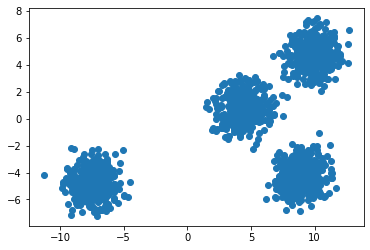

In [6]:
#generate data with K=4
X, y = make_blobs(n_samples=1500, centers=4)
plt.scatter(X[:, 0], X[:, 1])

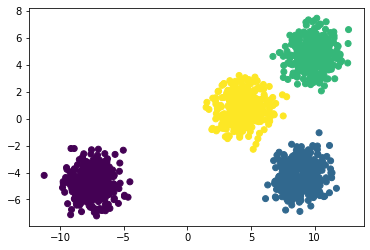

In [7]:
#K-Means ref implementation
k = KMeans(n_clusters=4)
y_pred = k.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)

In [8]:
k.cluster_centers_

array([[-7.40185093, -4.77465684],
       [ 8.90677225, -4.2999271 ],
       [ 9.85351908,  4.70784002],
       [ 4.39182143,  0.78472739]])

In [88]:
#implement map -> assign data to center 
def kMap( c ): 
  tc  = [0 for a in range(len(c))]
  for i in range(len(c)):
    tc[i] = (np.linalg.norm(X-c[i,:]))
  return tc.index(min(tc))

In [94]:
#implement reduce -> compute new centers
def kReduce( a,b ):
  return a+b


In [89]:
#init centers
center = X[np.random.randint(X.shape[0], size=4), :]#get 4 random datapoints
print('init center', center)

init center [[-7.86321217 -3.23792914]
 [10.10240685  4.62606821]
 [ 2.6160637   0.98368019]
 [ 9.14180719 -2.84929085]]


In [95]:
#use framework
mapper = SimpleMapReduce(kMap, kReduce)#get mapreduce instance with custom map and reduce functions
center = mapper(X)#call parallel mapreduce oo data

IndexError: ignored

In [62]:
tc  = [0 for a in range(len(center))]
tc

[0, 0, 0, 0]

In [64]:
for i in range(len(center)):
  tc[i] = (np.linalg.norm(X[0,:]-center[i,:]))


In [70]:
tc

[1.1395752580372778, 1.468278293808076, 6.495856675221468, 7.277727568671547]

In [45]:
((np.linalg.norm(X[0,:]-center[0,:])))

1.1395752580372778

In [69]:
tc.index(min(tc))

0